# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import sys

sys.path.append('../../src/utils')


# Utilities
from housing_prices_column_definition import Column

processedPath = '../../datasets/processed/housing_prices/hyderabad_house_price_processed.parquet'

train_features_path = '../../datasets/processed/housing_prices/hyderabad_house_price_training_features.parquet'
train_labels_path = '../../datasets/processed/housing_prices/hyderabad_house_price_training_labels.parquet'

test_features_path = '../../datasets/processed/housing_prices/hyderabad_house_price_test_features.parquet'
test_labels_path = '../../datasets/processed/housing_prices/hyderabad_house_price_test_labels.parquet'

dataset = pd.read_parquet(processedPath)

### 1.1 Split data

**Problem:**

A simple random split of the dataset into training, validation, and test sets can create imbalanced subsets. This means one set might accidentally contain a disproportionate number of expensive or cheap houses compared to the others. A model trained on such a skewed dataset will develop a bias, leading to poor generalization and inaccurate performance metrics when evaluated on the other sets.

**Justification:**

For a model's evaluation to be reliable, the training, validation, and test sets must be representative samples of the overall data distribution. By ensuring that the statistical properties of the target variable (in this case, the distribution of house prices) are consistent across all splits, we guarantee that the model learns the true underlying patterns from the data. This results in a more robust model that performs predictably on new, unseen data, and our evaluation metrics will reflect its true capabilities.

**Action:**

We will use stratified sampling to perform the data split. This technique divides the data into homogeneous subgroups (strata) based on the price distribution before sampling. By drawing proportional samples from each stratum to build the training, validation, and test sets, we ensure that each set is a faithful and balanced representation of the original dataset's price distribution.


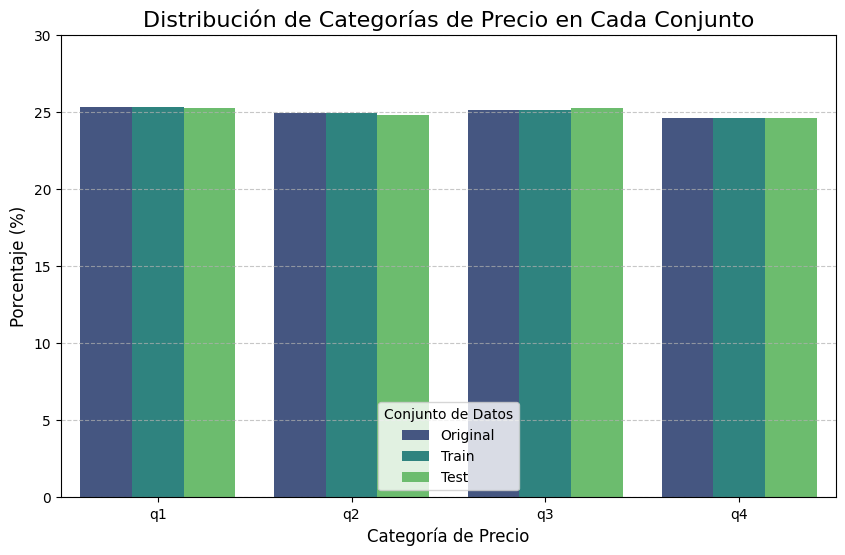

In [3]:

PRICE_CAT = 'price_cat'

dataset[PRICE_CAT] = pd.qcut(dataset[Column.PRICE.name], q=4, labels=['q1', 'q2', 'q3', 'q4'])

features = dataset.drop(Column.PRICE.name, axis=1)
labels = dataset[Column.PRICE.name]

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, stratify=features[PRICE_CAT], random_state=42
)

# # give the proportion of q1, q2, q3, q4 for each set
original_dist = features[PRICE_CAT].value_counts(normalize=True).sort_index()
train_dist = features_train[PRICE_CAT].value_counts(normalize=True).sort_index()
test_dist = features_test[PRICE_CAT].value_counts(normalize=True).sort_index()

comparison_df = pd.DataFrame({
    "Original": original_dist * 100,
    "Train": train_dist * 100,
    "Test": test_dist * 100
})


plot_data = comparison_df.reset_index().melt(
    id_vars=PRICE_CAT,
    var_name='Set',
    value_name='Percentage'
)


plot_data.rename(columns={PRICE_CAT: 'Price Category'}, inplace=True)

# Creamos el gráfico de barras (sin cambios)
plt.figure(figsize=(10, 6))
sns.barplot(x='Price Category', y='Percentage', hue='Set', data=plot_data, palette='viridis')

plt.title('Distribución de Categorías de Precio en Cada Conjunto', fontsize=16)
plt.xlabel('Categoría de Precio', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.ylim(0, 30)
plt.legend(title='Conjunto de Datos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig('stratified_split_verification.png')
plt.show()


# Limpieza final de la columna 'price_cat'
for set_ in (features_train, features_test):
    set_.drop(PRICE_CAT, axis=1, inplace=True)


features_train.to_parquet(train_features_path)
labels_train.to_frame().to_parquet(train_labels_path)

features_test.to_parquet(test_features_path)
labels_test.to_frame().to_parquet(test_labels_path)
